# Quantum clustering: the q-means algorithm on the MNIST dataset.

In this notebook we study the performances of Q-means algorithm on the MNIST dataset. Specifically, since q-means reduces to the classical algorithm $\delta$-k-means we just tested the performance of $\delta$-k-means. 

In [1]:
%matplotlib inline

import sys
import itertools
import random
from time import time

import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)


import seaborn as sns; sns.set()  # for plot styling

import numpy as np

from scipy.stats import mode

import sklearn as sk
from sklearn.metrics import accuracy_score
from sklearn.metrics import pairwise_distances_argmin
from sklearn.metrics import pairwise_distances
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import DMeans

from mnist import MNIST

import importlib
importlib.reload(sk)

from sklearn import datasets
digits = datasets.load_digits()


np.warnings.filterwarnings('ignore')

We load the data from a specific path. You might set this path to where you downloaded the dataset of MNIST. 

In [67]:
mndata = MNIST('/home/scinawa/workspace/hackedkit/python-mnist/data')
mndata = MNIST('/home/scinawa/workspace/hackedkit/python-mnist/data')
X_origin, y = mndata.load_training()
X_test_origin, y_test = mndata.load_testing()

y = np.array(y)
y_test = np.array(y_test)
X_origin = np.array(X_origin)
X_test_origin = np.array(X_test_origin)

Now you can choose which dimensionality reduction algorithm to apply. We picked LDA because it gives higher accuracy and because there is a quantum algorithm for projecting the data in the same subspace (Quantum Slow Feature Analysis)

In [68]:
#X_origin = sk.preprocessing.normalize(X_origin)

#dimred = PCA(n_components=35)
dimred = LinearDiscriminantAnalysis()

X = dimred.fit_transform(X_origin, y)
X_test = dimred.transform(X_test_origin)

### Testing that plain kmeans indeed gives good accuracy.

In [51]:
def find_labels(predicted, correct):
    labels_regular = np.zeros_like(correct)
    for i in np.unique(correct):        
        mask = (predicted == i)
        labels_regular[mask] = mode(correct[mask])[0]
    return labels_regular

kmeans = KMeans(n_clusters=10).fit(X)
predicted_ = kmeans.predict(X_test)
labels = find_labels(predicted_, y_test)


print("The accuracy score of k-means after DR is {:.3}%".format(accuracy_score(y_test, labels)))



The accuracy score of k-means after PCA is 0.863%


### Doing k-means again before dimensionality reduction, just to compare..

In [52]:
kmeans2 = KMeans(n_clusters=10).fit(X_origin)
predicted_origin_= kmeans2.predict(X_test_origin)
labels_origin = find_labels(predicted_origin_, y_test)

print("The accuracy score of k-means before PCA is {:.3}%".format(accuracy_score(y_test, labels_origin)))

The accuracy score of k-means before PCA is 0.595%


### Measuring the condition number

In [70]:
print(X.shape)
condition_number = np.linalg.cond(X)
print(condition_number)

(60000, 9)
1.8430468268340194


### Let's measure the value of Z on this dataset

In [6]:
norms = np.linalg.norm(X, axis=1)
norms_cluster =np.linalg.norm(kmeans.cluster_centers_, axis=1)

Z = max(norms)+max(norms_cluster)
print(Z)

4281.261923151289


## The experiment: measuring accuracy for k-means and d-means
For some number of iteration we measure the accuracy of our classifier, removing the outliers.

In [7]:
def find_labels(predicted, correct):
    labels_regular = np.zeros_like(correct)
    correct = np.array(correct)
    for i in np.unique(correct):        
        mask = (predicted == i)
        labels_regular[mask] = mode(correct[mask])[0]
    return labels_regular


def accuracy_kmeans(X, n_cluster, iteration_number, X_test, y_test, rseed):
    kmeans = KMeans(n_clusters=n_cluster, random_state=rseed, max_iter=iteration_number).fit(X)
    
    predicted_ = kmeans.predict(X_test)
    labels = find_labels(predicted_, y_test)
    
    accuracy = accuracy_score(np.array(y_test), labels)
    return accuracy

def accuracy_dmeans(X, n_cluster, iteration_number, X_test, y_test, delta, rseed):
    dmeans = DMeans(n_clusters=n_cluster, random_state=rseed, n_init=3, max_iter=iteration_number, delta=delta).fit(X)
    
    #import pdb
    #pdb.set_trace()    
    predicted_ = dmeans.predict(X_test)
    labels = find_labels(predicted_, y_test)
    
    accuracy = accuracy_score(np.array(y_test), labels)
    return accuracy

In [47]:
iterations_set = np.linspace(2, 10, 8, dtype=int)

results_kmeans = []
results_dmeans = []
results_dmeans_2 = []
results_kmeans_original = []
results_dmeans_original = []

delta = 0.3
delta_2 = 1
delta_original = 0.1

n_clusters = 10

for iterations in iterations_set:
    print("Running clustering algos with max {} iterations ".format(iterations))
    
    accuracy_set_kmeans = []
    accuracy_set_dmeans = []
    accuracy_set_dmeans_2 = []
    accuracy_set_kmeans_original = []
    accuracy_set_dmeans_original = []
    
    for sample in range(2): # this iteration is useless since we have n_iter from sklearn
        rseed=random.randint(10,50) #random initialization must be the same for comparing regular and delta kmeans
        
        #KMEANS
        accuracy = accuracy_kmeans(X, n_clusters, iterations, X_test, y_test, rseed)
        accuracy_set_kmeans.append(accuracy)

        #DMEANS
        accuracy = accuracy_dmeans(X, n_clusters, iterations, X_test, y_test, delta, rseed)
        accuracy_set_dmeans.append(accuracy)  

        # DMEANS 2
        accuracy = accuracy_dmeans(X, n_clusters, iterations, X_test, y_test, delta_2, rseed)       
        accuracy_set_dmeans_2.append(accuracy)  
        
        #KMEANS NO-DR
        accuracy = accuracy_kmeans(X_origin, n_clusters, iterations, X_test_origin, y_test, rseed)
        accuracy_set_kmeans_original.append(accuracy)
        
        # DMEANS NO-DR 
        accuracy = accuracy_dmeans(X_origin, n_clusters, iterations, X_test_origin, y_test, delta_original,rseed)       
        accuracy_set_dmeans_original.append(accuracy)  
        
        #import pdb
        #pdb.set_trace()
        print(" run {} | (DR) k-means:{:.2%} - q-means:{:.2%} - q-means_2:{:.2%} | (no-DR) k-means:{:.2%} - d-means:{:.2%} ".format(         
            sample, accuracy_set_kmeans[-1], accuracy_set_dmeans[-1], accuracy_set_dmeans_2[-1], accuracy_set_kmeans_original[-1], accuracy_set_dmeans_original[-1] ))    

    results_kmeans.append(np.average(accuracy_set_kmeans))
    results_dmeans.append(np.average(accuracy_set_dmeans))
    results_dmeans_2.append(np.average(accuracy_set_dmeans_2))
    results_kmeans_original.append(np.average(accuracy_set_kmeans_original))
    results_dmeans_original.append(np.average(accuracy_set_dmeans_original))
    

Running clustering algos with max 2 iterations 
 run 0 | (DR) k-means:86.39% - q-means:80.26% - q-means_2:77.99% | (no-DR) k-means:57.96% - d-means:57.96% 
 run 1 | (DR) k-means:86.04% - q-means:85.35% - q-means_2:78.59% | (no-DR) k-means:60.18% - d-means:51.68% 
Running clustering algos with max 3 iterations 
 run 0 | (DR) k-means:86.44% - q-means:86.02% - q-means_2:82.64% | (no-DR) k-means:57.76% - d-means:52.91% 
 run 1 | (DR) k-means:86.56% - q-means:85.94% - q-means_2:81.08% | (no-DR) k-means:58.87% - d-means:58.87% 
Running clustering algos with max 4 iterations 
 run 0 | (DR) k-means:86.24% - q-means:85.81% - q-means_2:82.68% | (no-DR) k-means:58.31% - d-means:53.00% 
 run 1 | (DR) k-means:86.31% - q-means:85.97% - q-means_2:79.68% | (no-DR) k-means:54.57% - d-means:57.29% 
Running clustering algos with max 5 iterations 
 run 0 | (DR) k-means:86.37% - q-means:86.07% - q-means_2:76.75% | (no-DR) k-means:58.64% - d-means:58.63% 
 run 1 | (DR) k-means:86.27% - q-means:85.94% - q-me

## Now we plot the accuracy for all the experiments on MNIST

In [48]:
iterations_set = np.insert(iterations_set, 0,0)
#iterations_set = [0,2, 7]
results_kmeans = [0] + results_kmeans
results_dmeans = [0] + results_dmeans
results_dmeans_2 = [0] + results_dmeans_2
results_kmeans_original = [0] + results_kmeans_original
results_dmeans_original = [0] + results_dmeans_original

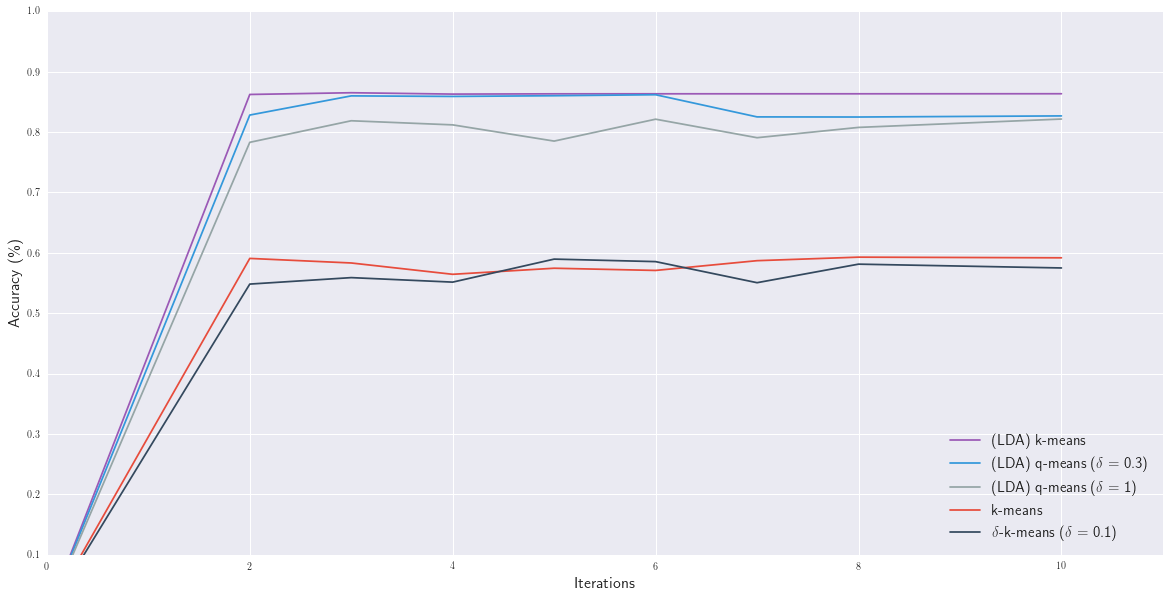

In [49]:
import matplotlib.lines as mlines
plt.figure(figsize=(20,10))

#iterations_set = [0,2,3,4,5,6,7,8,9]

plot_k = plt.plot(iterations_set,results_kmeans,'#9b59b6', label="(LDA) k-means")
plot_d = plt.plot(iterations_set,results_dmeans,'#3498db', label="(LDA) q-means ($\delta$ = 0.3)")
plot_d_2 = plt.plot(iterations_set,results_dmeans_2,'#95a5a6', label="(LDA) q-means ($\delta$ = 1)")
plot_k_non_dr = plt.plot(iterations_set,results_kmeans_original,'#e74c3c', label="k-means")
tplot_d_non_dr = plt.plot(iterations_set,results_dmeans_original,'#34495e', label="$\delta$-k-means ($\delta$ = 0.1)")


#blue_line = mlines.Line2D(iterations_set, results_kmeans, color='#004c6d', marker='*', markersize=15, label='(LDA) k-means')
#red_line = mlines.Line2D(iterations_set, results_dmeans, color='#7fc0cd', marker='*', markersize=15, label='(LDA) \delta-k-means  0.3')
#yellow_line = mlines.Line2D(iterations_set, results_dmeans_2, color='#e5ffff', marker='.', markersize=15, label='(LDA) \delta-k-means 0.4')
#green_line = mlines.Line2D(iterations_set, results_kmeans_original, color='#35ffff', marker='.', markersize=15, label='\delta-k-means 0.5')


plt.xlabel('Iterations ', fontsize=16)
plt.ylabel('Accuracy (\%)', fontsize=16)


plt.xlim(0, 11)
plt.ylim(0.1, 1)
plt.grid(True)

plt.legend(loc='lower right', ncol=1, shadow=True, fancybox=True, prop={'size': 15}) #, labels=['kmeans', 'dmeans'])

# Part 2: Other measure of good of clustering

In this part of the notebook we compared other measure of performances between delta-k-means and k-means for a small enough value of delta.

From http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html

In [ ]:
np.random.seed(42)

In [29]:
def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('%-9s\t%i\t\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))

In [37]:
digits = load_digits()
data = scale(digits.data)
delta = 0.8
n_samples, n_features = data.shape
n_digits = len(np.unique(digits.target))
labels = digits.target
sample_size = 300

print('init \t\tinertia \t homo\t compl\t v-meas\t ARI \t AMI \t silhouette')

bench_k_means(KMeans(init='k-means++', n_clusters=n_digits, n_init=10, algorithm="full"),
                  name="k-means++", data=data)

bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=10),
                  name="random", data=data)

# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
pca = PCA(n_components=n_digits).fit(data)
bench_k_means(KMeans(init=pca.components_, n_clusters=n_digits, n_init=1), name="k-means (PCA)", data=data)

print(30 * '=', "D-means", 30 * "=")


bench_k_means(DMeans(init='k-means++', n_clusters=n_digits, n_init=10, delta=delta), name="d-means++", data=data)

bench_k_means(DMeans(init='random', n_clusters=n_digits, n_init=10, delta=delta), name="d-means random", data=data)

# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
pca = PCA(n_components=n_digits).fit(data)
bench_k_means(DMeans(init=pca.components_, n_clusters=n_digits, n_init=1, delta=delta), name="d-means (PCA)", data=data)

init 		inertia 	 homo	 compl	 v-meas	 ARI 	 AMI 	 silhouette
k-means++	69644		0.575	0.648	0.610	0.455	0.571	0.134
random   	69464		0.608	0.655	0.631	0.476	0.604	0.143
k-means (PCA)	70803		0.670	0.697	0.683	0.561	0.667	0.123
============================== D-means ==============================
d-means++	69663		0.530	0.570	0.550	0.418	0.526	0.137
d-means random	69687		0.537	0.577	0.556	0.423	0.532	0.113
d-means (PCA)	102633		0.014	0.014	0.014	0.002	0.004	-0.059


# Appendix: implementation of delta-k-means (not ++)

In [ ]:
def label_with_delta(X,centers,delta): #give X (points) and centers: 2 numpy arrays
    labels = []
    count = 0 #to count the number of times we chose a random center
    for dist_array in pairwise_distances(X,centers): #dist_array is the array of distances between on element Xi of X and each cluster! 
        mindist = np.min(dist_array) #distance between Xi and its closest clusters
        normalmin = [np.argmin(dist_array)] # index of the clusters closest to Xi
        close_dist = set([dist for dist in dist_array if abs(dist-mindist)<delta]) #array of all distance of dist_array if they are delta-close to mindist 
        deltamin = [i for i, item in enumerate(dist_array) if item in close_dist] #index of delta-close centers 
        deltachoice = random.choice(deltamin) #choose randomly one of the delta-close centers
        labels.append(deltachoice)
        if deltamin!=normalmin:
            count+=1
    #print("DELTA K-MEANS: %d random choices of centers over %d"%(count,len(X)))
    return np.array(labels),count

def label_regular(X,centers):
    return pairwise_distances_argmin(X,centers)

def lossfunction(X,labels,centers):
    N = len(X)
    loss = 1/np.sqrt(N)*np.sum([np.linalg.norm(X[i]-centers[labels[i]]) for i in range(N)])
    return loss


def find_clusters_regular(X, n_clusters, threshold, iterations=None):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    step = 0
    loss = []
    
    while True:
        step+=1
        #print("step: {}".format(step))
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers) #REGULAR KMEANS
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0) for i in range(n_clusters)])
        loss_step = lossfunction(X,labels,new_centers)
        loss.append(loss_step)
        #if step==1:
            #print("step: {}".format(step))
            #plot_regular_clusters(X,labels,loss)
        
        if step>1:
            
            #if step%2==0:
                #print("step: {}".format(step))
                #print("loss_step: {}".format(loss_step))
                #print("LossDiff: {}".format(abs(loss_step - loss[-2])))
                #plot_regular_clusters(X,labels,loss)
                
            # 2c. Check for convergence //!!\\change for threshold on Loss
            if iterations == None:
                if abs(loss_step - loss[-2])<threshold:
                    #print("loss_step - loss[-2] = "+str(loss_step)+" - "+str(loss[-2])+" = "+str(loss_step - loss[-2]))
                    #print("step: {}".format(step))
                    #print("LossDiff: {}".format(abs(loss_step - loss[-2])))
                    #plot_regular_clusters(X,labels,loss)
                    break                   
            else:
                if step == iterations:
                    #print("END OF ITERATIONS")
                    #print("loss_step - loss[-2] = "+str(loss_step)+" - "+str(loss[-2])+" = "+str(loss_step - loss[-2]))
                    #print("step: {}".format(step))
                    #print("LossDiff: {}".format(abs(loss_step - loss[-2])))
                    #plot_regular_clusters(X,labels,loss)
                    break                    
        centers = new_centers
    return centers, labels


def find_clusters_delta(X, n_clusters, delta, threshold, iterations=None):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    step = 0
    random_choices = []
    loss = []
    
    while True:
        step+=1
        
        # 2a. Assign labels based on closest center
        labels, count = label_with_delta(X,centers,delta) #DELTA KMEANS
        random_choices.append(count)
        
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0) for i in range(n_clusters)])
        loss_step = lossfunction(X,labels,new_centers)
        loss.append(loss_step)
        
        #if step==1:
            #print("step: {}".format(step))
            #plot_delta_clusters(X,labels,random_choices,loss)

        if step>1:
            
            #if step%2==0:
                #print("step: {}".format(step))
                #print("loss_step: {}".format(loss_step))
                #print("LossDiff: {}".format(abs(loss_step - loss[-2])))
                #plot_delta_clusters(X,labels,random_choices,loss)


            # 2c. Check for convergence //!!\\change for threshold on Loss
            if iterations == None:
                
                if abs(loss_step - loss[-2])<threshold:
                    #print("loss_step - loss[-2] = "+str(loss_step)+" - "+str(loss[-2])+" = "+str(loss_step - loss[-2]))
                    #print("step: {}".format(step))
                    #print("LossDiff: {}".format(abs(loss_step - loss[-2])))
                    #plot_delta_clusters(X,labels,random_choices,loss)
                    break
                    
            else:
                if step == iterations:
                    #print("END OF ITERATIONS")
                    #print("loss_step - loss[-2] = "+str(loss_step)+" - "+str(loss[-2])+" = "+str(loss_step - loss[-2]))
                    #print("step: {}".format(step))
                    #print("LossDiff: {}".format(abs(loss_step - loss[-2])))
                    #plot_delta_clusters(X,labels,random_choices,loss)
                    break
                
        centers = new_centers

    return centers, labels, random_choices